In [3]:
'''
【项目07】  城市餐饮店铺选址分析

1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型
要求：
① 计算出三个维度的指标得分
② 评价方法：
   口味 → 得分越高越好
   性价比 → 得分越高越好
   人均消费 → 价格适中即可
③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”
   绘制柱状图，分别显示“口味得分”、“性价比得分”
   * 建议用bokeh做图
备注：
性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理

'''

'\n【项目07】  城市餐饮店铺选址分析\n\n1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型\n要求：\n① 计算出三个维度的指标得分\n② 评价方法：\n   口味 → 得分越高越好\n   性价比 → 得分越高越好\n   人均消费 → 价格适中即可\n③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”\n   绘制柱状图，分别显示“口味得分”、“性价比得分”\n   * 建议用bokeh做图\n提示：\n① 数据清洗，清除空值、为0的数据\n② 口味指标计算方法 → 口味评分字段，按照餐饮类别分组算均值，再做标准化处理\n③ 人均消费指标计算方法 → 人均消费字段，按照餐饮类别分组算均值，再做标准化处理\n④ 性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理\n⑤ 数据计算之前，检查一下数据分布，去除异常值（以外限为标准）\n   * 这里排除了高端奢侈餐饮的数据干扰\n⑥ 注意，这里先分别计算三个指标，再合并数据（merge）作图，目的是指标之间的噪音数据不相互影响\n\n2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置\n* 课程这里以“素菜馆为例”\n课程数据\n① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据\n② road.shp → 投影坐标西，上海道路数据\n要求：\n① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标\n② 评价方法：\n   人口密度指标 → 得分越高越好\n   道路密度指标 → 得分越高越好\n   餐饮热度指标 → 得分越高越好\n   同类竞品指标 → 得分越低越好\n   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1\n③ 最后得到较好选址的网格位置的中心坐标，以及所属区域\n   * 可以用bokeh制作散点图\n提示：\n① 道路密度指标计算方法 → 网格内道路长度\n② 餐饮热度指标计算方法 → 网格内餐饮poi计数\n③ 同类竞品指标计算方法 →

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

In [2]:
df1 = pd.read_excel('data_set/上海餐饮数据.xlsx', sheet_name=0, header=0)

In [3]:
df1_length = len(df1)
df1.rename(columns={
    '类别': 'type',
    '行政区': 'district',
    '点评数': 'comments_count',
    '口味': 'taste',
    '环境': 'environment',
    '服务': 'service',
    '人均消费': 'price',
    '城市': 'city'
},
           inplace=True)
df1_columns = df1.columns.tolist()

In [4]:
df1_length

96398

In [5]:
df1_columns

['type',
 'district',
 'comments_count',
 'taste',
 'environment',
 'service',
 'price',
 'city',
 'Lng',
 'Lat']

In [6]:
df1.head()

,type,district,comments_count,taste,environment,service,price,city,Lng,Lat
0,烧烤,浦东新区,176,8.0,8.6,7.9,124,上海市,121.967860,30.884477
1,美食,闵行区,2,6.1,6.5,6.3,0,上海市,121.967781,30.883818
2,粤菜,浦东新区,141,6.7,7.2,6.6,141,上海市,121.933142,30.893224
3,海鲜,浦东新区,76,7.2,7.2,7.3,148,上海市,121.926062,30.899868
4,烧烤,浦东新区,600,7.2,7.6,7.0,143,上海市,121.925877,30.901100


In [7]:
df1.groupby(['type'])['price'].mean()

type
亚菜     76.342105
助餐     92.267380
北菜     27.990716
午茶    150.000000
南菜     71.779221
啡厅     30.167417
川菜     31.486958
州菜     48.220339
常菜      7.160377
快餐     17.359878
料理     47.069138
本菜    113.779851
浙菜     60.770415
海鲜     56.670674
湘菜     29.482041
湾菜     55.254302
火锅     74.836038
烧烤     37.721261
甜点     19.250242
疆菜     36.163594
粤菜     81.860278
素菜     57.005618
美食     22.989821
蟹宴     34.530120
西菜     26.590909
西餐     89.082344
面馆     25.285714
龙虾     39.205619
Name: price, dtype: float64

In [8]:
df1.isnull().sum()

type              140
district          143
comments_count      0
taste               0
environment         0
service             0
price               0
city                0
Lng                 0
Lat                 0
dtype: int64

In [9]:
df1.describe()

,comments_count,taste,environment,service,price,Lng,Lat
count,96398.000000,96398.000000,96398.000000,96398.000000,96398.000000,96398.000000,96398.000000
mean,411.028206,6.085184,6.069038,6.053736,41.854406,121.417234,31.217374
std,1440.151809,2.933487,2.936946,2.924225,88.238019,0.175437,0.136149
min,0.000000,0.000000,0.000000,0.000000,0.000000,106.175198,18.241289
25%,2.000000,6.800000,6.700000,6.700000,0.000000,121.367003,31.177550
50%,19.000000,7.200000,7.100000,7.200000,18.000000,121.437232,31.226206
75%,186.000000,7.600000,7.600000,7.600000,54.000000,121.481277,31.269262
max,38643.000000,9.400000,9.400000,9.500000,6309.000000,121.967860,37.997707


In [10]:
df1['price'].value_counts()[:50]

0     40532
15     1294
17     1260
18     1193
16     1103
20     1095
19      978
22      972
30      921
14      919
25      900
27      875
21      864
35      861
28      840
26      785
24      774
40      761
23      739
32      714
36      687
13      682
38      679
31      672
33      668
37      667
29      659
34      652
39      616
12      572
11      557
50      553
41      527
45      512
10      509
43      464
44      456
42      428
46      410
47      401
48      383
60      364
51      356
53      353
80      349
65      344
55      343
58      339
76      337
82      335
Name: price, dtype: int64

<AxesSubplot:ylabel='Frequency'>

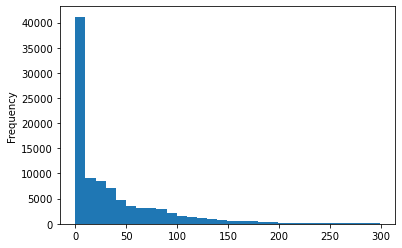

In [11]:
df1[df1['price'] < 300]['price'].plot(kind='hist', bins=30)

In [12]:
# 口味、客单价、性价比指标计算

data1 = df1[['type', 'taste', 'environment', 'service', 'price']]
data1.dropna(inplace=True)
data1 = data1[(data1['taste'] > 0) & (data1['price'] > 0)]

In [13]:
data1.shape

(54889, 5)

In [14]:
data1['cost_effective'] = (data1['taste'] + data1['environment'] +
                           data1['service']) / data1['price']

<AxesSubplot:>

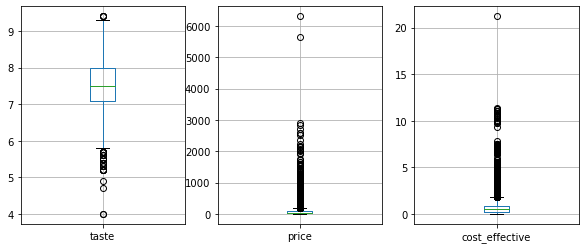

In [16]:
# 性价比图表
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
data1.boxplot(column=['taste'], ax=axes[0])
data1.boxplot(column=['price'], ax=axes[1])
data1.boxplot(column=['cost_effective'], ax=axes[2])

In [17]:
# 删除异常
def clean_f1(data, col):
    q1 = data[col].quantile(q=0.25)
    q3 = data[col].quantile(q=0.75)
    iqr = q3 - q1
    t1 = q1 - 3 * iqr
    t2 = q3 + 3 * iqr
    return data[(data[col] > t1) & (data[col] < t2)][['type', col]]


data_taste = clean_f1(data1, 'taste')
data_price = clean_f1(data1, 'price')
data_coste = clean_f1(data1, 'cost_effective')

In [18]:
data_taste.head()

,type,taste
0,烧烤,8.0
2,粤菜,6.7
3,海鲜,7.2
4,烧烤,7.2
5,本菜,8.2


In [19]:
def clean_f2(data, col):
    col_name = col + '_norm'
    data_mean = data.groupby('type').mean()
    data_mean[col_name] = (data_mean[col] - data_mean[col].min()) / (
        data_mean[col].max() - data_mean[col].min())
    data_mean.sort_values(by=col_name, inplace=True, ascending=False)
    return data_mean


data_taste_score = clean_f2(data_taste, 'taste')
data_price_score = clean_f2(data_price, 'price')
data_coste_score = clean_f2(data_coste, 'cost_effective')

In [20]:
data_taste_score.head(10)

,taste,taste_norm
type,,
素菜,8.021705,1.000000
南菜,7.984874,0.948128
本菜,7.959824,0.912848
火锅,7.949428,0.898206
亚菜,7.889937,0.814421
蟹宴,7.873469,0.791228
西餐,7.853583,0.763221
疆菜,7.791221,0.675392
州菜,7.772500,0.649026


In [21]:
# 合并标准化得分
data_final_s1 = pd.merge(data_taste_score,
                         data_price_score,
                         left_index=True,
                         right_index=True)
data_final = pd.merge(data_final_s1,
                      data_coste_score,
                      left_index=True,
                      right_index=True)
data_final.head()

,taste,taste_norm,price,price_norm,cost_effective,cost_effective_norm
type,,,,,,
素菜,8.021705,1.000000,71.251969,0.364955,0.497415,0.371044
南菜,7.984874,0.948128,91.411765,0.527529,0.325731,0.182992
本菜,7.959824,0.912848,111.316243,0.688044,0.287742,0.141381
火锅,7.949428,0.898206,98.524051,0.584884,0.282454,0.135589
亚菜,7.889937,0.814421,94.426724,0.551842,0.310835,0.166675


In [22]:
from bokeh.models import HoverTool
from bokeh.palettes import brewer
from bokeh.models.annotations import BoxAnnotation
from bokeh.layouts import gridplot

In [23]:
data_final['size'] = data_final['taste_norm'] * 40
source = ColumnDataSource(data_final)

In [24]:
hover = HoverTool(tooltips=[("餐饮类型", "@type"), ("人均消费", "@price"),
                            ("性价比得分", "@cost_effective_norm"),
                            ("口味得分", "@taste_norm")])  # 设置标签显示内容

In [25]:
result = figure(plot_width=800,
                plot_height=250,
                title='餐饮类型得分情况',
                x_axis_label='人均消费',
                y_axis_label='性价比得分',
                tools=[hover, 'box_select,reset,xwheel_zoom,pan,crosshair'])
result.circle(x='price',
              y='cost_effective_norm',
              source=source,
              line_color='black',
              line_dash=[6, 4],
              fill_alpha=0.6,
              size='size')

price_mid = BoxAnnotation(left=40, right=80, fill_alpha=0.1, fill_color='navy')
result.add_layout(price_mid)

result.title.text_font_style = 'bold'
result.ygrid.grid_line_dash = [6, 4]
result.xgrid.grid_line_dash = [6, 4]

In [26]:
# 绘制柱状图
data_type = data_final.index.tolist()

kw = figure(plot_width=800,
            plot_height=250,
            title='口味得分',
            x_range=data_type,
            tools=[hover, 'box_select,reset,xwheel_zoom,pan,crosshair'])
kw.vbar(x='type', top='taste_norm', source=source, width=0.9, alpha=0.8, color='red')
kw.ygrid.grid_line_dash=[6, 4]
kw.xgrid.grid_line_dash=[6, 4]

In [27]:
price=figure(plot_width=800,
            plot_height=250,
            title='人均消费得分',
            x_range=kw.x_range,
            tools=[hover, 'box_select,reset,xwheel_zoom,pan,crosshair'])
price.vbar(x='type', top='price_norm', source=source, width=0.9, alpha=0.8, color='green')
price.ygrid.grid_line_dash=[6, 4]
price.xgrid.grid_line_dash=[6, 4]

In [28]:
p=gridplot([[result], [kw], [price]])
show(p)

In [134]:
'''
2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置
* 课程这里以“素菜馆为例”
课程数据
① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据
② road.shp → 投影坐标西，上海道路数据
要求：
① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标
② 评价方法：
   人口密度指标 → 得分越高越好
   道路密度指标 → 得分越高越好
   餐饮热度指标 → 得分越高越好
   同类竞品指标 → 得分越低越好
   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1
③ 最后得到较好选址的网格位置的中心坐标，以及所属区域
   * 可以用bokeh制作散点图
'''

'\n2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置\n* 课程这里以“素菜馆为例”\n课程数据\n① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据\n② road.shp → 投影坐标西，上海道路数据\n要求：\n① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标\n② 评价方法：\n   人口密度指标 → 得分越高越好\n   道路密度指标 → 得分越高越好\n   餐饮热度指标 → 得分越高越好\n   同类竞品指标 → 得分越低越好\n   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1\n③ 最后得到较好选址的网格位置的中心坐标，以及所属区域\n   * 可以用bokeh制作散点图\n提示：\n① 道路密度指标计算方法 → 网格内道路长度\n② 餐饮热度指标计算方法 → 网格内餐饮poi计数\n③ 同类竞品指标计算方法 → 网格内素菜馆poi计数\n④ 餐饮poi数据记得投影\n⑤ 可以以“net_population.shp”为网格基础数据，做空间统计\n⑥ 在qgis做空间统计之后，网格数据导出点数据，投影成wgs84地理坐标系，导出excel数据，在python做指标标准化等\n⑦ 在bokeh中做散点图时，注意添加一个size字段，通过最终评分来赋值\n⑧ 在bokeh中做散点图时，可以给TOP10的点用颜色区分\n'

In [29]:
df2=pd.read_csv('data_set/上海素菜餐厅数据.csv')
df2.head()

,Z,road_length,road_count,restaurant_count,veg_count,lng,lat
0,212,1735.529165,16,0,0,120.857,31.103164
1,280,562.285197,11,0,0,120.857,31.112181
2,125,0.000000,0,0,0,120.867,31.121372
3,284,0.000000,0,0,0,120.867,31.130388
4,148,0.000000,0,0,0,120.867,31.094321


In [30]:
# 标准化
data2=df2.drop('road_count', axis=1)
data2['Z_norm']=(data2['Z']-data2['Z'].min())/(data2['Z'].max()-data2['Z'].min())
data2['rest_norm']=(data2['restaurant_count']-data2['restaurant_count'].min())/(data2['restaurant_count'].max()-data2['restaurant_count'].min())
data2['veg_norm']=(data2['veg_count'].max()-data2['veg_count'])/(data2['veg_count'].max()-data2['veg_count'].min())
data2['road_norm']=(data2['road_length']-data2['road_length'].min())/(data2['road_length'].max()-data2['road_length'].min())

In [31]:
data2['final_score']=data2['Z_norm']*0.4+data2['rest_norm']*0.3+data2['veg_norm']*0.1+data2['road_norm']*0.2
dataFinal=data2.sort_values(by='final_score', ascending=False).reset_index()
dataFinal.head(10)

,index,Z,road_length,restaurant_count,veg_count,lng,lat,Z_norm,rest_norm,veg_norm,road_norm,final_score
0,4004,35036,15485.338560,1244,2,121.473,31.238244,0.820688,1.000000,0.846154,0.528646,0.818620
1,4009,36929,9310.585816,1186,2,121.473,31.229224,0.865030,0.953376,0.846154,0.317849,0.780210
2,3822,36929,14012.301510,1049,3,121.452,31.228973,0.865030,0.843248,0.769231,0.478359,0.771581
3,3918,36929,14434.934660,895,3,121.463,31.211060,0.865030,0.719453,0.769231,0.492787,0.737328
4,3821,36929,12106.065150,972,4,121.452,31.219953,0.865030,0.781350,0.692308,0.413283,0.732304
5,4010,42691,11964.048340,504,0,121.473,31.274322,1.000000,0.405145,1.000000,0.408434,0.703230
6,4008,35036,14049.202500,803,3,121.473,31.220204,0.820688,0.645498,0.769231,0.479618,0.694772
7,4102,35036,9235.897916,789,0,121.484,31.238368,0.820688,0.634244,1.000000,0.315299,0.681608
8,4095,42691,11849.317080,403,0,121.483,31.265427,1.000000,0.323955,1.000000,0.404518,0.678090
9,4093,40623,14091.374860,362,0,121.483,31.247388,0.951559,0.290997,1.000000,0.481058,0.664134


In [32]:
dataFinal['size']=dataFinal['final_score']*20
dataFinal['color']='green'
dataFinal['color'].iloc[:10]='red'

source=ColumnDataSource(dataFinal)

hover = HoverTool(tooltips=[("经度", "@lng"),
                            ("纬度", "@lat"),
                            ("最终得分", "@final_score"),
                           ])  # 设置标签显示内容

In [33]:
p=figure(plot_width=800, plot_height=800,title='空间散点图', tools=[hover,'box_select,reset,wheel_zoom,pan,crosshair'])
p.square(x='lng', y='lat', source=source, line_color='black', fill_alpha=0.5, size='size', color='color')
p.ygrid.grid_line_dash=[6,4]
p.xgrid.grid_line_dash=[6,4]
show(p)